In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow.pytorch
import numpy as np

import mlflow

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust to your project's structure
sys.path.append(project_root)

from src.analysis import *

In [2]:
# Set MLFlow tracking URI (local or server-based)
mlflow.set_tracking_uri("sqlite:///mlflow.db")  # Change if using a centralized server

# Define the experiment name
mlflow.set_experiment("MVP Prediction NN")

mlflow.set_tag("developer", "christophe")

In [3]:
# Load your cleaned dataset
data_path = "/Users/cb/src/nba_mvp_ml/data/processed/by_season/fully_merged/final_stacked_data.csv"

_X, _y = load_and_preprocess_data(data_path, remove_excess_features=False) # X will be normalized


# Example input data
np.random.seed(42)
X =_X.to_numpy().astype(np.float32)
y = _y.to_numpy().astype(np.int64)  # Binary labels

# Determine sizes for train, validation, and test splits
train_size = int(0.7 * len(X))  # 70% for training
val_size = int(0.15 * len(X))   # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

# Split the datase
X_train = torch.tensor(X[:train_size])
y_train = torch.tensor(y[:train_size])

X_val= torch.tensor(X[train_size:train_size + val_size])
y_val= torch.tensor(y[train_size:train_size + val_size])

X_test = torch.tensor(X[train_size + val_size:])
y_test = torch.tensor(y[train_size + val_size:])

_y_test = _y[train_size + val_size:]

# Check the shapes of each split
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Train set: torch.Size([206, 184]) torch.Size([206])
Validation set: torch.Size([44, 184]) torch.Size([44])
Test set: torch.Size([45, 184]) torch.Size([45])


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple neural network
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)

# Hyperparameters
input_size = len(_X.columns)
hidden_size = 64
output_size = 2
learning_rate = 0.001
num_epochs = 200

# Initialize the model, loss function, and optimizer
model = SimpleMLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
with mlflow.start_run(nested=True):
    # Log hyperparameters
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("output_size", output_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)

    mlflow.log_param("n_features", len(_X.columns))

    mlflow.log_param("model_name", 'fc3_layer')

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

    # Log the trained model
    mlflow.pytorch.log_model(model, "model")

    print("Model training complete and logged in MLflow.")


    # TEST PERFORMANCE ALANYSIS ------------------------------------------------------------------------------
    
    model.eval()

    # Pass the input tensor to the model
    with torch.no_grad(): 
        predictions = model(X_test)
    
    y_pred = torch.argmax(predictions, dim=1)

    y_true = y_test

    # Calculate True Positives, False Positives, and False Negatives
    tp = ((y_true == 1) & (y_pred == 1)).sum()  # True Positives
    fp = ((y_true == 0) & (y_pred == 1)).sum()  # False Positives
    fn = ((y_true == 1) & (y_pred == 0)).sum()  # False Negatives
    tn = ((y_true == 0) & (y_pred == 0)).sum()  # True Negatives
    
    # Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("accuracy", accuracy)
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

Epoch [1/200], Loss: 0.6593
Validation Loss: 0.6151, Accuracy: 86.36%
Epoch [2/200], Loss: 0.5788
Validation Loss: 0.5421, Accuracy: 86.36%
Epoch [3/200], Loss: 0.5115
Validation Loss: 0.4852, Accuracy: 86.36%
Epoch [4/200], Loss: 0.4596
Validation Loss: 0.4583, Accuracy: 86.36%
Epoch [5/200], Loss: 0.4470
Validation Loss: 0.4482, Accuracy: 86.36%
Epoch [6/200], Loss: 0.4547
Validation Loss: 0.4422, Accuracy: 86.36%
Epoch [7/200], Loss: 0.4427
Validation Loss: 0.4340, Accuracy: 86.36%
Epoch [8/200], Loss: 0.4235
Validation Loss: 0.4247, Accuracy: 84.09%
Epoch [9/200], Loss: 0.4069
Validation Loss: 0.4187, Accuracy: 86.36%
Epoch [10/200], Loss: 0.3962
Validation Loss: 0.4098, Accuracy: 88.64%
Epoch [11/200], Loss: 0.3929
Validation Loss: 0.3982, Accuracy: 88.64%
Epoch [12/200], Loss: 0.3796
Validation Loss: 0.3836, Accuracy: 93.18%
Epoch [13/200], Loss: 0.3708
Validation Loss: 0.3755, Accuracy: 95.45%
Epoch [14/200], Loss: 0.3700
Validation Loss: 0.3671, Accuracy: 95.45%
Epoch [15/200],

2024/12/05 20:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training complete and logged in MLflow.
Precision: 0.800000011920929
Recall: 0.5714285969734192
Accuracy: 0.9111111164093018


In [6]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.800000011920929
Recall: 0.5714285969734192
Accuracy: 0.9111111164093018


In [7]:
# subset_indexes = _y_test.index

y_pred_np = y_pred.numpy()

true_positive = _y_test.reset_index().loc[(_y_test.reset_index()['mvp'] == 1) & (y_pred_np == 1)]
false_positive = _y_test.reset_index().loc[(_y_test.reset_index()['mvp'] == 0) & (y_pred_np == 1)]
false_negative = _y_test.reset_index().loc[(_y_test.reset_index()['mvp'] == 1) & (y_pred_np == 0)]
true_negative = _y_test.reset_index().loc[(_y_test.reset_index()['mvp'] == 0) & (y_pred_np == 0)]

# print(f"true_positive:\n {true_positive}")
# print(f"false_positive:\n {false_positive}")
# print(f"false_negative:\n {false_negative}")

cross_refs_path = "/Users/cb/src/nba_mvp_ml/data/processed/by_season/fully_merged/player_index_mapping.csv"
cross_refs = pd.read_csv(cross_refs_path)

print('\nCorrectly predicted as MVP')
for i in list(true_positive['index']):
    player = cross_refs.iloc[i]['Player']
    season = write_season(int(cross_refs.iloc[i]['SEASON_ID']))
    
    print(f'{season} {player}')

print('\nIncorrectly predicted as MVP')
for i in list(false_positive['index']):
    player = cross_refs.iloc[i]['Player']
    season = write_season(int(cross_refs.iloc[i]['SEASON_ID']))
    
    print(f'{season} {player}')

print('\nIncorrectly predicted as non-MVP')
for i in list(false_negative['index']):
    player = cross_refs.iloc[i]['Player']
    season = write_season(int(cross_refs.iloc[i]['SEASON_ID']))
    
    print(f'{season} {player}')

print('\nCorrectly predicted as non-MVP')
for i in list(true_negative['index']):
    player = cross_refs.iloc[i]['Player']
    season = write_season(int(cross_refs.iloc[i]['SEASON_ID']))
    
    print(f'{season} {player}')


Correctly predicted as MVP
1984-85 LARRY BIRD
2003-04 KEVIN GARNETT
2011-12 LEBRON JAMES
1999-00 SHAQUILLE O'NEAL

Incorrectly predicted as MVP
2001-02 JASON KIDD

Incorrectly predicted as non-MVP
1994-95 DAVID ROBINSON
2022-23 JOEL EMBIID
2001-02 TIM DUNCAN

Correctly predicted as non-MVP
1984-85 MAGIC JOHNSON
1984-85 MOSES MALONE
1984-85 TERRY CUMMINGS
1994-95 CHARLES BARKLEY
1994-95 HAKEEM OLAJUWON
1994-95 KARL MALONE
1994-95 PATRICK EWING
1994-95 SCOTTIE PIPPEN
1994-95 SHAQUILLE O'NEAL
2003-04 BEN WALLACE
2003-04 JERMAINE O'NEAL
2003-04 KOBE BRYANT
2003-04 SHAQUILLE O'NEAL
2003-04 TIM DUNCAN
2011-12 CHRIS PAUL
2011-12 DWIGHT HOWARD
2011-12 KEVIN DURANT
2011-12 KEVIN LOVE
2011-12 KOBE BRYANT
2011-12 TONY PARKER
1999-00 ALLEN IVERSON
1999-00 ALONZO MOURNING
1999-00 GARY PAYTON
1999-00 KARL MALONE
1999-00 KEVIN GARNETT
1999-00 TIM DUNCAN
2022-23 DOMANTAS SABONIS
2022-23 DONOVAN MITCHELL
2022-23 GIANNIS ANTETOKOUNMPO
2022-23 JAYSON TATUM
2022-23 NIKOLA JOKIĆ
2022-23 SHAI GILGEOUS-ALEX

In [8]:
from captum.attr import IntegratedGradients
import torch

# Ensure model is in evaluation mode
model.eval()

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Input tensor (e.g., a single sample or a batch)
input_tensor = X_test[0:1]  # Example: Select the first test sample

# Baseline (reference point for attributions, typically zero)
baseline = torch.zeros_like(input_tensor)

# Compute attributions
attributions, delta = ig.attribute(
    input_tensor, 
    baseline, 
    target=1,  # Explain predictions for class 1 (MVP)
    return_convergence_delta=True
)

# Display attributions
print("Feature Importance (Integrated Gradients):", attributions)

Feature Importance (Integrated Gradients): tensor([[ 1.4290e-03, -1.2882e-02, -1.9556e-02, -5.3814e-03, -3.7526e-03,
         -7.1443e-04,  5.4439e-05, -1.0204e-02,  1.9462e-04, -5.1617e-03,
         -9.3249e-05, -1.8668e-03, -8.3906e-04,  1.8532e-02, -1.1785e-02,
          7.2976e-03, -5.8220e-03, -1.5616e-02, -1.1839e-02, -8.3794e-03,
         -1.0950e-03,  1.6753e-03, -2.6003e-03, -2.1344e-03,  1.8701e-02,
         -6.4234e-03,  4.0526e-03, -2.3671e-03, -8.5802e-03, -4.9084e-05,
         -8.3920e-04, -6.9924e-03,  8.4273e-03, -1.3698e-02,  2.5310e-03,
         -8.9042e-03,  2.0360e-03,  2.9995e-05, -5.7757e-03, -2.8258e-03,
         -4.1801e-03,  2.5728e-05,  9.1605e-04,  8.6427e-04, -1.3173e-02,
         -1.5485e-02,  8.2965e-04,  2.3643e-03, -1.0831e-03,  9.1057e-04,
         -6.1323e-03,  2.1301e-03, -4.3682e-02, -3.3188e-03, -1.1478e-02,
         -9.5565e-03, -1.4298e-04, -1.5300e-04,  1.2743e-03,  2.5525e-03,
         -2.2788e-03,  1.1807e-03, -1.5937e-02, -2.5663e-02, -8.2665e

/opt/anaconda3/envs/nba_mvp_ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



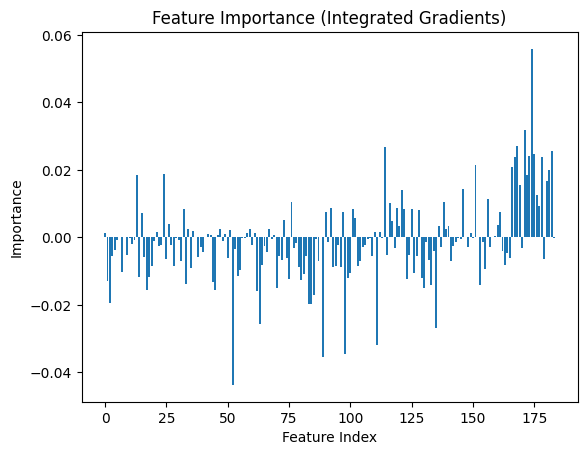

In [9]:



# Convert to numpy for easy plotting
feature_importance = attributions.detach().numpy().flatten()

# Plot
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance (Integrated Gradients)")
plt.show()

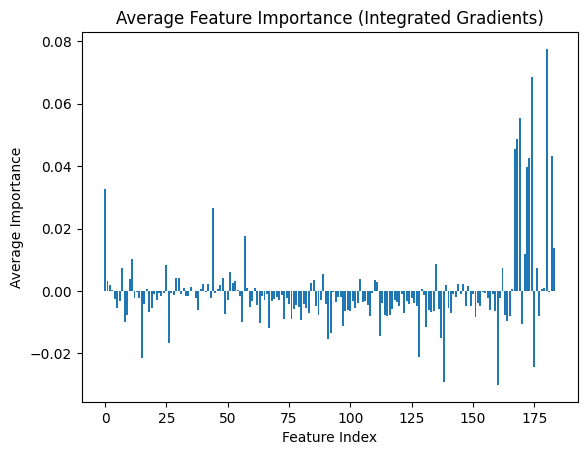

In [10]:
import numpy as np
import matplotlib.pyplot as plt

all_attributions = []

for input_tensor in X_test:
    # Input tensor is a single sample of shape (24,)
    input_tensor = input_tensor.unsqueeze(0)  # Reshape to (1, 24)
    
    # Baseline must match the input tensor shape
    baseline = torch.zeros_like(input_tensor)  # Shape (1, 24)
    
    # Compute attributions
    attributions = ig.attribute(input_tensor, baseline, target=1)
    all_attributions.append(attributions.detach().numpy())

# Average attributions across the dataset
mean_attributions = np.mean(np.array(all_attributions), axis=0)

# Plot average feature importance
plt.bar(range(len(mean_attributions[0])), mean_attributions[0])
plt.xlabel("Feature Index")
plt.ylabel("Average Importance")
plt.title("Average Feature Importance (Integrated Gradients)")
plt.show()

In [11]:
dict(zip(_X.columns, list(mean_attributions[0])))

{'index': 0.03264243547809816,
 'FGM': 0.0031012834060918006,
 'FGA_player': 0.002020454632457851,
 'FG3M': 0.0002269425388291721,
 'FG3A': -0.0025680402936378807,
 'FTM': -0.005382548119814882,
 'FTA_player': -0.0033149027832771734,
 'OREB': 0.007432054433041352,
 'DREB': -0.01009852603823253,
 'REB': -0.00774884117495511,
 'STL_player': 0.0037848699838016,
 'BLK_player': 0.010272050211684832,
 'TOV_player': -0.002144785254934688,
 'PF_player': -0.00022092883428367457,
 'PTS_player': -0.002323923857915103,
 'MIN_PG': -0.021566947264408765,
 'FGM_PG': -0.004335560112294638,
 'FGA_PG': 0.00046133526289801445,
 'FG_PCT_PG': -0.00685677547046722,
 'FG3M_PG': -0.005412932324968017,
 'FG3A_PG': -0.0009856149184498536,
 'FG3_PCT_PG': -0.0030285350029004756,
 'FTM_PG': -0.0005402586407285335,
 'FTA_PG': -0.0016779035626989544,
 'FT_PCT_PG': -0.0006960343014087752,
 'OREB_PG': 0.008420914300413678,
 'DREB_PG': -0.016740658623853204,
 'REB_PG': -0.0006911363953818096,
 'AST_PG': -0.001331117867